In [44]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [3]:

default_image_size = tuple((256, 256))
# directory_root = 'C:/Users/Sakib Mukter/Desktop/RiceProject/Segmented/CrowdAI-Train-Test/color'
directory_root = 'N:/RiceDetectionGithub/Custom-Train-Test(color)/color'


width=256
height=256
depth=3

In [45]:
from tqdm import tqdm

image_list, label_list = [], []
# write_dir = 'C:/Users/Sakib Mukter/Desktop/RiceProject/Segmented/Processed/'

write_dir = 'N:/RiceDetectionGithub/Segmented/Processed'

print("[INFO] Loading images ...")
root_dir = listdir(directory_root)
for img_folder in tqdm(root_dir):
    print("Processing: ",img_folder)
    plant_disease_image_list = listdir(f"{directory_root}/{img_folder}/")
    print("Images: ",len(plant_disease_image_list))
    for img_name in plant_disease_image_list:
        img_url = directory_root + '/' + img_folder + '/' +img_name
        img = cv2.imread(img_url) #reading image
        # hue sat value -hsv
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        #Green upper and lowerbound
        lower_green = np.array([36,0,0])
        upper_green = np.array([86,255,255])
        
        mask = cv2.inRange(hsv, lower_green, upper_green)
        
        lower_yellow = np.array([15,20,30])
        upper_yellow = np.array([86,100,100])
        
        mask = cv2.inRange(hsv, lower_green, upper_green)
        res = cv2.bitwise_and(img,img, mask= mask)
#         plt.subplot(131),plt.imshow(img,cmap = 'gray'),plt.title("img")
#         plt.xticks([]), plt.yticks([])
#         plt.subplot(132),plt.imshow(mask,cmap = 'gray'),plt.title('mask')
#         plt.xticks([]), plt.yticks([])
#         plt.subplot(133),plt.imshow(res,cmap = 'gray'),plt.title('res')
#         plt.xticks([]), plt.yticks([])
#         plt.show()
        
        img_write = write_dir + '/' + img_folder + '/' + img_name
        cv2.imwrite(img_write,res)
       
        
    
     

[INFO] Loading images ...


  0%|                                                                                      | 0/25 [00:00<?, ?it/s]

Processing:  Apple___Apple_scab
Images:  600


  4%|███                                                                           | 1/25 [00:04<01:54,  4.75s/it]

Processing:  Apple___Black_rot
Images:  591


  8%|██████▏                                                                       | 2/25 [00:12<02:07,  5.53s/it]

Processing:  Apple___Cedar_apple_rust
Images:  245


 12%|█████████▎                                                                    | 3/25 [00:14<01:44,  4.74s/it]

Processing:  Apple___healthy
Images:  1615


 16%|████████████▍                                                                 | 4/25 [00:35<03:19,  9.52s/it]

Processing:  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Images:  483


 20%|███████████████▌                                                              | 5/25 [00:41<02:48,  8.43s/it]

Processing:  Corn_(maize)___Common_rust_
Images:  1162


 24%|██████████████████▋                                                           | 6/25 [00:55<03:12, 10.12s/it]

Processing:  Corn_(maize)___healthy
Images:  1132


 28%|█████████████████████▊                                                        | 7/25 [01:09<03:20, 11.16s/it]

Processing:  Corn_(maize)___Northern_Leaf_Blight
Images:  955


 32%|████████████████████████▉                                                     | 8/25 [01:20<03:12, 11.32s/it]

Processing:  Grape___Black_rot
Images:  1150


 36%|████████████████████████████                                                  | 9/25 [01:36<03:21, 12.60s/it]

Processing:  Grape___Esca_(Black_Measles)
Images:  1353


 40%|██████████████████████████████▊                                              | 10/25 [01:54<03:32, 14.19s/it]

Processing:  Grape___healthy
Images:  393


 44%|█████████████████████████████████▉                                           | 11/25 [01:58<02:37, 11.27s/it]

Processing:  Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Images:  1046


 48%|████████████████████████████████████▉                                        | 12/25 [02:10<02:29, 11.53s/it]

Processing:  Potato___Early_blight
Images:  970


 52%|████████████████████████████████████████                                     | 13/25 [02:22<02:19, 11.65s/it]

Processing:  Potato___healthy
Images:  122


 56%|███████████████████████████████████████████                                  | 14/25 [02:24<01:34,  8.57s/it]

Processing:  Potato___Late_blight
Images:  970


 60%|██████████████████████████████████████████████▏                              | 15/25 [02:35<01:34,  9.45s/it]

Processing:  Tomato___Bacterial_spot
Images:  2097


 64%|█████████████████████████████████████████████████▎                           | 16/25 [03:02<02:11, 14.56s/it]

Processing:  Tomato___Early_blight
Images:  970


 68%|████████████████████████████████████████████████████▎                        | 17/25 [03:14<01:51, 13.95s/it]

Processing:  Tomato___healthy
Images:  1561


 72%|███████████████████████████████████████████████████████▍                     | 18/25 [03:36<01:53, 16.26s/it]

Processing:  Tomato___Late_blight
Images:  1879


 76%|██████████████████████████████████████████████████████████▌                  | 19/25 [03:59<01:49, 18.23s/it]

Processing:  Tomato___Leaf_Mold
Images:  922


 80%|█████████████████████████████████████████████████████████████▌               | 20/25 [04:10<01:20, 16.12s/it]

Processing:  Tomato___Septoria_leaf_spot
Images:  1741


 84%|████████████████████████████████████████████████████████████████▋            | 21/25 [04:33<01:12, 18.05s/it]

Processing:  Tomato___Spider_mites Two-spotted_spider_mite
Images:  1646


 88%|███████████████████████████████████████████████████████████████████▊         | 22/25 [04:53<00:56, 18.79s/it]

Processing:  Tomato___Target_Spot
Images:  1374


 92%|██████████████████████████████████████████████████████████████████████▊      | 23/25 [05:10<00:36, 18.26s/it]

Processing:  Tomato___Tomato_mosaic_virus
Images:  343


 96%|█████████████████████████████████████████████████████████████████████████▉   | 24/25 [05:14<00:13, 13.96s/it]

Processing:  Tomato___Tomato_Yellow_Leaf_Curl_Virus
Images:  5327


100%|█████████████████████████████████████████████████████████████████████████████| 25/25 [06:22<00:00, 30.32s/it]


[INFO] Loading images ...
Processing:  Apple___Apple_scab
Images:  600


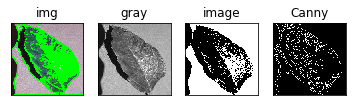

error: OpenCV(3.4.4) C:\projects\opencv-python\opencv\modules\imgproc\src\grabcut.cpp:381: error: (-215:Assertion failed) !bgdSamples.empty() && !fgdSamples.empty() in function 'initGMMs'


In [29]:
#Contour Extraction

image_list, label_list = [], []
# write_dir = 'C:/Users/Sakib Mukter/Desktop/RiceProject/Segmented/Processed/'

write_dir = 'N:/RiceDetectionGithub/Segmented/Processed'

print("[INFO] Loading images ...")
root_dir = listdir(directory_root)
for img_folder in root_dir:
    print("Processing: ",img_folder)
    plant_disease_image_list = listdir(f"{directory_root}/{img_folder}/")
    print("Images: ",len(plant_disease_image_list))
    for img_name in plant_disease_image_list:
        img_url = directory_root + '/' + img_folder + '/' +img_name
        im = cv2.imread(img_url) #reading image
        
        #Threshholding contour detect
        imgray  = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(imgray,127,255,0)
        image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        
        
        imgc = cv2.drawContours(im, contours, -1, (0,255,0), 3)

        #Canny 
        edges = cv2.Canny(im,100,200)
           
        plt.subplot(141),plt.imshow(im,cmap = 'gray'),plt.title("img")
        plt.xticks([]), plt.yticks([])
        plt.subplot(142),plt.imshow(imgray,cmap = 'gray'),plt.title('gray')
        plt.xticks([]), plt.yticks([])
        plt.subplot(143),plt.imshow(image,cmap = 'gray'),plt.title('image')
        plt.xticks([]), plt.yticks([])
        plt.subplot(144),plt.imshow(edges,cmap = 'gray'),plt.title('Canny')
        plt.xticks([]), plt.yticks([])
        plt.show()
        
        
        
        img_write = write_dir + '/' + img_folder + '/' + img_name
        cv2.imwrite(img_write,res)
       
        break
        

## Grabcut

In [36]:

im = cv2.imread(img_url) #reading image
im = cv2.blur(im, (5,5))

height, width = im.shape[:2]

mask = np.ones(im.shape[:2], dtype=np.uint8) * 2 #start all possible background
'''
#from docs:
0 GC_BGD defines an obvious background pixels.
1 GC_FGD defines an obvious foreground (object) pixel.
2 GC_PR_BGD defines a possible background pixel.
3 GC_PR_FGD defines a possible foreground pixel.
'''

#2 circles are "drawn" on mask. a smaller centered one I assume all pixels are definite foreground. a bigger circle, probably foreground.
r = 100
cv2.circle(mask, (int(width/2.), int(height/2.)), 2*r, 3, -3) #possible fg
#next 2 are greens...dark and bright to increase the number of fg pixels.
mask[(im[:,:,0] < 45) & (im[:,:,1] > 55) & (im[:,:,2] < 55)] = 1  #dark green
mask[(im[:,:,0] < 190) & (im[:,:,1] > 190) & (im[:,:,2] < 200)] = 1  #bright green
mask[(im[:,:,0] > 200) & (im[:,:,1] > 200) & (im[:,:,2] > 200) & (mask != 1)] = 0 #pretty white

cv2.circle(mask, (int(width/2.), int(height/2.)), r, 1, -3) #fg



bgdmodel = np.zeros((1,65), np.float64)
fgdmodel = np.zeros((1,65), np.float64)
cv2.grabCut(im, mask, None, bgdmodel, fgdmodel, 1, cv2.GC_INIT_WITH_MASK)


plt.figure(figsize=(10,10))
plt.imshow(mask)
plt.show()

#mask image
mask2 = np.where((mask==1) + (mask==3), 255, 0).astype('uint8')
output = cv2.bitwise_and(im, im, mask=mask2)
plt.figure(figsize=(10,10))
plt.imshow(output)
plt.show()



error: OpenCV(3.4.4) C:\projects\opencv-python\opencv\modules\imgproc\src\grabcut.cpp:381: error: (-215:Assertion failed) !bgdSamples.empty() && !fgdSamples.empty() in function 'initGMMs'


In [29]:
import os

In [32]:
write_dir = 'C:/Users/Sakib Mukter/Desktop/RiceProject/Segmented/Processed/'


In [36]:
# for c in root_dir:
#     dira = write_dir + '/' + c
#     os.mkdir(dira)